# Lab: Linear Models and Regularization Methods

In [1]:
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Subset Selection Methods

### Best Subset Selection

Here we apply the best subset selection approach to the `Hitters` data.
We wish to predict a baseball player's `Salary` on the basis of various statistics associated with performance in the previous year.

First of all, we note that the `Salary` variable is missing for some of the players.  The `isna()` function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a `TRUE` for any elements that are missing, and a `FALSE` for non-missing elements.
The `sum()` function can then be used to count all of the missing elements.

In [2]:
Hitters = pd.read_csv('data/Hitters.csv')
Hitters.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague'],
      dtype='object')

In [3]:
Hitters.Salary.isna().sum()

59

Hence we see that `Salary` is missing for $59$ players. The `na.omit()` function removes all of the rows that have missing values in any variable.

In [5]:
Hitters = Hitters.dropna()
Hitters.shape

(263, 20)

In [6]:
Hitters.Salary.isna().sum()

0

In [7]:
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


Then we select our data matrix and target variable.

In [8]:
X = Hitters.drop(columns='Salary')
y = Hitters.Salary

Since there is no available Python module to perform best subset selection, define some helper functions to train and score the models.

In [9]:
def fit_model(y, X):
    # Fit the model
    X = pd.get_dummies(X, drop_first=True)
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    return model


def regsubsets(y, X, nvmax=8):
    columns = X.columns
    
    # Iterate over models with k columns, find best k model
    models = []
    for k in range(1, min(nvmax, len(columns)) + 1):
        
        # Find best k model using RSS
        min_rss = np.inf
        for subset in combinations(columns, k):
            model_k = fit_model(y, X[list(subset)])
            if model_k.ssr < min_rss:
                best_subset = subset
                best_k = model_k
                min_rss = model_k.ssr

        # For best k model get scores
        scores = {
            'k': k,
            'subset': best_subset,
            'model': best_k,
            'rsq': best_k.rsquared,
            'rss': best_k.ssr ,
            'adjr2': best_k.rsquared_adj,
            'bic': best_k.bic,
            'aic': best_k.aic
        }
        models.append(scores)
    return pd.DataFrame(models)

In [54]:
%%time
models_bss = regsubsets(y, X, 19)
models_bss

CPU times: user 13min 40s, sys: 4.3 s, total: 13min 44s
Wall time: 13min 44s


,k,subset,model,rsq,rss,adjr2,bic,aic
0,1,"(CRBI,)",<statsmodels.regression.linear_model.Regressio...,0.321450,3.617968e+07,0.318850,3869.283615,3862.139307
1,2,"(Hits, CRBI)",<statsmodels.regression.linear_model.Regressio...,0.425224,3.064656e+07,0.420802,3831.203767,3820.487305
2,3,"(Hits, CRBI, PutOuts)",<statsmodels.regression.linear_model.Regressio...,0.451429,2.924930e+07,0.445075,3824.503056,3810.214440
3,4,"(Hits, CRBI, Division, PutOuts)",<statsmodels.regression.linear_model.Regressio...,0.475407,2.797085e+07,0.467273,3818.321064,3800.460294
4,5,"(AtBat, Hits, CRBI, Division, PutOuts)",<statsmodels.regression.linear_model.Regressio...,0.490804,2.714990e+07,0.480897,3816.058548,3794.625624
5,6,"(AtBat, Hits, Walks, CRBI, Division, PutOuts)",<statsmodels.regression.linear_model.Regressio...,0.508715,2.619490e+07,0.497200,3812.213078,3787.208000
6,7,"(Hits, Walks, CAtBat, CHits, CHmRun, Division,...",<statsmodels.regression.linear_model.Regressio...,0.514123,2.590655e+07,0.500785,3814.874046,3786.296813
7,8,"(AtBat, Hits, Walks, CHmRun, CRuns, CWalks, Di...",<statsmodels.regression.linear_model.Regressio...,0.528557,2.513693e+07,0.513708,3812.514735,3780.365349
8,9,"(AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...",<statsmodels.regression.linear_model.Regressio...,0.534612,2.481405e+07,0.518057,3814.686826,3778.965286
9,10,"(AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...",<statsmodels.regression.linear_model.Regressio...,0.540495,2.450040e+07,0.522261,3816.913469,3777.619775


This takes a while, as we are fitting many models. How many?

In [9]:
from math import comb

nmodels = 0
for k in range(1, 19+1):
    nmodels += comb(19, k)
nmodels

524287

In [10]:
# Average time in seconds to fit each model
15*60/nmodels

0.0017166170437184214

So even if each model is very fast to fit, best subset selection is a very computionally intensive algorithm. Here, fitting each model takes about 20 ms.

The `regsubsets()` function tries to imitate the R function with the same name. The function performs best subset selection by identifying the best model that contains a given number of predictors, where *best* is quantified using RSS. The output is the best set of variables for each model size.

The column `subset` contains tha variables in the each best k model.
For instance, this output indicates that the best two-variable model contains only `Hits` and `CRBI`.
By default, `regsubsets()` only reports results up to the best eight-variable model. But the  `nvmax` option can be used in order to return as many variables as are desired.

The function also returns $R^2$, RSS, adjusted $R^2$, and BIC. We can examine these to try to select the *best* overall model.

For instance, we see that the $R^2$ statistic increases from $32\,\%$, when only one variable is included in the model, to almost $55\,\%$, when all variables are included. As expected, the $R^2$ statistic increases monotonically as more variables are included.

In [60]:
models_bss.rsq

0     0.321450
1     0.425224
2     0.451429
3     0.475407
4     0.490804
5     0.508715
6     0.514123
7     0.528557
8     0.534612
9     0.540495
10    0.542615
11    0.543630
12    0.544457
13    0.545216
14    0.545469
15    0.545766
16    0.545952
17    0.546095
18    0.546116
Name: rsq, dtype: float64

Plotting RSS, adjusted $R^2$, AIC, and BIC for all of the models at once will help us decide which model to select.

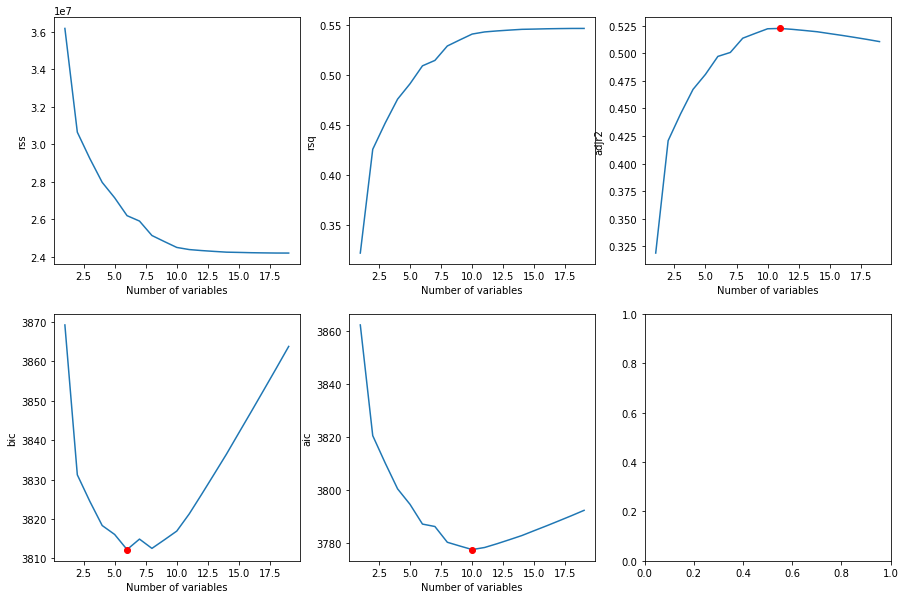

In [62]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax = ax.ravel()
for i, metric in enumerate(['rss', 'rsq', 'adjr2', 'bic', 'aic']):
    ax[i].plot(models_bss.k, models_bss[metric])
    ax[i].set_xlabel('Number of variables')
    ax[i].set_ylabel(metric)
    if metric == 'adjr2':
        max_idx = models_bss[metric].values.argmax()
        ax[i].plot([models_bss.k.iloc[max_idx]], [models_bss[metric].iloc[max_idx]], 'ro')
    if metric in ['bic', 'aic']:
        min_idx = models_bss[metric].values.argmin()
        ax[i].plot([models_bss.k.iloc[min_idx]], [models_bss[metric].iloc[min_idx]], 'ro')

The `argmax()` function can be used to identify the location of the maximum point of a vector. We used the function to plot a red dot to indicate the model with the largest adjusted $R^2$ statistic. Similarly we used `argmin()` to plot a red dot to indicate the models with the smallest BIC and AIC statistics.

For instance, we see that several models share a BIC close to $3800$. However, the model with the lowest BIC is the six-variable model that contains only `AtBat`,
`Hits`,  `Walks`, `CRBI`, `DivisionW`, and `PutOuts`.
We can use the `params` attribute to see the coefficient estimates associated with this model.

In [63]:
models_bss[models_bss.k == 6].model.iloc[0].params

const          91.511798
AtBat          -1.868589
Hits            7.604398
Walks           3.697647
CRBI            0.643017
PutOuts         0.264308
Division_W   -122.951534
dtype: float64

### Forward and Backward Stepwise Selection
 

We can also use the define functions to perform forward stepwise or backward stepwise selection with some modifications to the best subset selection strategy defined above.
When using forward or backward selection, we are performing a directed search over the space of available models wich results in a lot less models fitted:

In [18]:
nmodels = 0
p = 19
for k in range(p):
    nmodels += (p - k)
nmodels

190

In [52]:
def forward_selection(y, X, nvmax=8):
    columns = X.columns
    
    # Iterate over models with k columns,
    # add single predictor at a time
    models = []
    # Empty subset to begin with
    subset = []
    # List of available predictors
    predictors = X.columns.tolist()
    
    for k in range(1, min(nvmax, len(columns)) + 1):
        
        # Find best k model using RSS
        min_rss = np.inf
        for pred in predictors:
            model_k = fit_model(y, X[subset + [pred]])
            if model_k.ssr < min_rss:
                best_k = model_k
                min_rss = model_k.ssr
                best_pred = pred
        # Update subset and predictors
        subset.append(best_pred)
        predictors.remove(best_pred)

        # For best k model get scores
        scores = {
            'k': k,
            'subset': subset.copy(),
            'model': best_k,
            'rsq': best_k.rsquared,
            'rss': best_k.ssr ,
            'adjr2': best_k.rsquared_adj,
            'bic': best_k.bic,
            'aic': best_k.aic
        }
        models.append(scores)
    return pd.DataFrame(models)

In [53]:
%%time
models_fs =forward_selection(y, X, 19)
models_fs

CPU times: user 279 ms, sys: 3.6 ms, total: 283 ms
Wall time: 284 ms


,k,subset,model,rsq,rss,adjr2,bic,aic
0,1,[CRBI],<statsmodels.regression.linear_model.Regressio...,0.321450,3.617968e+07,0.318850,3869.283615,3862.139307
1,2,"[CRBI, Hits]",<statsmodels.regression.linear_model.Regressio...,0.425224,3.064656e+07,0.420802,3831.203767,3820.487305
2,3,"[CRBI, Hits, PutOuts]",<statsmodels.regression.linear_model.Regressio...,0.451429,2.924930e+07,0.445075,3824.503056,3810.214440
3,4,"[CRBI, Hits, PutOuts, Division]",<statsmodels.regression.linear_model.Regressio...,0.475407,2.797085e+07,0.467273,3818.321064,3800.460294
4,5,"[CRBI, Hits, PutOuts, Division, AtBat]",<statsmodels.regression.linear_model.Regressio...,0.490804,2.714990e+07,0.480897,3816.058548,3794.625624
5,6,"[CRBI, Hits, PutOuts, Division, AtBat, Walks]",<statsmodels.regression.linear_model.Regressio...,0.508715,2.619490e+07,0.497200,3812.213078,3787.208000
6,7,"[CRBI, Hits, PutOuts, Division, AtBat, Walks, ...",<statsmodels.regression.linear_model.Regressio...,0.513229,2.595422e+07,0.499866,3815.357536,3786.780304
7,8,"[CRBI, Hits, PutOuts, Division, AtBat, Walks, ...",<statsmodels.regression.linear_model.Regressio...,0.528139,2.515923e+07,0.513277,3812.747991,3780.598605
8,9,"[CRBI, Hits, PutOuts, Division, AtBat, Walks, ...",<statsmodels.regression.linear_model.Regressio...,0.534612,2.481405e+07,0.518057,3814.686826,3778.965286
9,10,"[CRBI, Hits, PutOuts, Division, AtBat, Walks, ...",<statsmodels.regression.linear_model.Regressio...,0.540495,2.450040e+07,0.522261,3816.913469,3777.619775


In [40]:
def backward_selection(y, X, nvmax=8):
    columns = X.columns
    p = len(columns)
    
    # Iterate over models with k columns,
    # removing single predictor at a time
    # Empty subset to begin with
    subset = columns.tolist()
    
    # Fit full model
    best_k = fit_model(y, X)
    scores = {
            'k': p,
            'subset': subset.copy(),
            'model': best_k,
            'rsq': best_k.rsquared,
            'rss': best_k.ssr ,
            'adjr2': best_k.rsquared_adj,
            'bic': best_k.bic,
            'aic': best_k.aic
        }
    models = [scores]
    
    for i in range(1, min(nvmax, p)):
        k = p - i
        # Find best k model using RSS
        min_rss = np.inf
        for pred in subset:
            temp_set = subset.copy()
            temp_set.remove(pred)
            model_k = fit_model(y, X[temp_set])
            if model_k.ssr < min_rss:
                best_k = model_k
                min_rss = model_k.ssr
                worst_pred = pred
        # Update subset and predictors
        subset.remove(worst_pred)
        
        # For best k model get scores
        scores = {
            'k': k,
            'subset': subset.copy(),
            'model': best_k,
            'rsq': best_k.rsquared,
            'rss': best_k.ssr ,
            'adjr2': best_k.rsquared_adj,
            'bic': best_k.bic,
            'aic': best_k.aic
        }
        models.append(scores)
    return pd.DataFrame(models)

In [43]:
%%time
models_bs = backward_selection(y, X, 19)
models_bs

CPU times: user 367 ms, sys: 2.98 ms, total: 370 ms
Wall time: 369 ms


,k,subset,model,rsq,rss,adjr2,bic,aic
0,19,"[AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...",<statsmodels.regression.linear_model.Regressio...,0.546116,2.420070e+07,0.510627,3863.825860,3792.382780
1,18,"[AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...",<statsmodels.regression.linear_model.Regressio...,0.546095,2.420184e+07,0.512610,3858.266071,3790.395144
2,17,"[AtBat, Hits, HmRun, Runs, RBI, Walks, CAtBat,...",<statsmodels.regression.linear_model.Regressio...,0.545952,2.420945e+07,0.514446,3852.776595,3788.477822
3,16,"[AtBat, Hits, HmRun, Runs, RBI, Walks, CAtBat,...",<statsmodels.regression.linear_model.Regressio...,0.545766,2.421938e+07,0.516222,3847.312301,3786.585683
4,15,"[AtBat, Hits, HmRun, Runs, Walks, CAtBat, CHit...",<statsmodels.regression.linear_model.Regressio...,0.545469,2.423518e+07,0.517866,3841.911664,3784.757199
5,14,"[AtBat, Hits, HmRun, Runs, Walks, CAtBat, CRun...",<statsmodels.regression.linear_model.Regressio...,0.545216,2.424866e+07,0.519543,3836.485787,3782.903476
6,13,"[AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI...",<statsmodels.regression.linear_model.Regressio...,0.544457,2.428915e+07,0.520674,3831.352392,3781.342235
7,12,"[AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI...",<statsmodels.regression.linear_model.Regressio...,0.543630,2.433323e+07,0.521724,3826.257147,3779.819145
8,11,"[AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...",<statsmodels.regression.linear_model.Regressio...,0.542615,2.438735e+07,0.522571,3821.269208,3778.403359
9,10,"[AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal...",<statsmodels.regression.linear_model.Regressio...,0.540495,2.450040e+07,0.522261,3816.913469,3777.619775


For instance, we see that using forward stepwise selection, the best one-variable model contains only `CRBI`, and the best two-variable model additionally includes `Hits`. For this data, the best one-variable through six-variable models are each identical for best subset and forward selection. However, the best seven-variable models identified by forward stepwise selection, backward stepwise selection, and best subset selection are different.

In [55]:
print(sorted(models_bss[models_bss.k == 7].subset.iloc[0]))
print(sorted(models_fs[models_fs.k == 7].subset.iloc[0]))
print(sorted(models_bs[models_bs.k == 7].subset.iloc[0]))

['CAtBat', 'CHits', 'CHmRun', 'Division', 'Hits', 'PutOuts', 'Walks']
['AtBat', 'CRBI', 'CWalks', 'Division', 'Hits', 'PutOuts', 'Walks']
['AtBat', 'CRuns', 'CWalks', 'Division', 'Hits', 'PutOuts', 'Walks']


### Choosing Among Models Using the Validation-Set Approach and Cross-Validation

We just saw that it is possible to choose among a set of models of different sizes using $C_p$, BIC, and adjusted $R^2$. We will now consider how to do this using the
validation set and cross-validation approaches.

In order for these approaches to yield accurate estimates of the test
error, we must use *only the training observations* to perform all aspects of model-fitting---including variable
  selection.  Therefore, the determination of which model of a
given size is best must be made using *only the training observations*. This point is subtle but important.
If the full data set is used to perform the best subset selection
step, the validation set errors and cross-validation errors that we
obtain will not be accurate estimates of the test error.

In order to use the validation set approach, we begin by splitting the
observations into a training set and a test set.

In [56]:
from sklearn.model_selection import train_test_split

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

Now, we apply `regsubsets()` to the training set in order to perform best subset selection.

In [93]:
%%time
model_best = regsubsets(y_train, X_train, 19)
model_best

CPU times: user 13min 28s, sys: 1.29 s, total: 13min 29s
Wall time: 13min 29s


,k,subset,model,rsq,rss,adjr2,bic,aic
0,1,"(CRBI,)",<statsmodels.regression.linear_model.Regressio...,0.324850,2.059478e+07,0.319617,1948.973246,1943.222851
1,2,"(CRBI, PutOuts)",<statsmodels.regression.linear_model.Regressio...,0.459530,1.648651e+07,0.451085,1924.701589,1916.075997
2,3,"(Walks, CRBI, PutOuts)",<statsmodels.regression.linear_model.Regressio...,0.500671,1.523154e+07,0.488876,1919.204948,1907.704159
3,4,"(CAtBat, CHits, CRuns, PutOuts)",<statsmodels.regression.linear_model.Regressio...,0.537863,1.409703e+07,0.523192,1913.940242,1899.564256
4,5,"(Walks, CAtBat, CHits, CHmRun, PutOuts)",<statsmodels.regression.linear_model.Regressio...,0.559751,1.342937e+07,0.542141,1912.459312,1895.208128
5,6,"(Walks, CAtBat, CHits, CHmRun, Division, PutOuts)",<statsmodels.regression.linear_model.Regressio...,0.580704,1.279021e+07,0.560416,1910.946362,1890.819980
6,7,"(Walks, CAtBat, CHits, CHmRun, CWalks, Divisio...",<statsmodels.regression.linear_model.Regressio...,0.585186,1.265349e+07,0.561579,1914.413732,1891.412154
7,8,"(AtBat, Hits, Walks, CAtBat, CHits, CHmRun, Di...",<statsmodels.regression.linear_model.Regressio...,0.595439,1.234074e+07,0.568910,1916.010373,1890.133597
8,9,"(AtBat, Hits, Walks, CAtBat, CHits, CHmRun, Di...",<statsmodels.regression.linear_model.Regressio...,0.598991,1.223238e+07,0.569164,1919.730271,1890.978297
9,10,"(AtBat, Hits, Walks, CAtBat, CHits, CHmRun, Le...",<statsmodels.regression.linear_model.Regressio...,0.601715,1.214928e+07,0.568525,1923.712478,1892.085308


Notice that we subset the `Hitters` data frame directly in the call in order to access only the training subset of the data, using `X_train`.
We now compute the validation set error for the best model of each model size.

In [94]:
val_errors = []
for i, row in model_best.iterrows():
    m = row.model
    subset = list(row.subset)
    X_k = sm.add_constant(pd.get_dummies(X_test[subset], drop_first=True))
    preds = m.predict(X_k)
    val_errors.append(((preds - y_test)**2).mean())
val_errors

[118361.56861419103,
 130966.87007469594,
 119625.21024441488,
 134907.9885306005,
 112643.04978289087,
 107270.9475703039,
 116458.80105099842,
 106841.13014819437,
 105173.662776405,
 106397.80219778293,
 108477.9562984262,
 108578.20210232891,
 109159.87954120857,
 111403.2671982661,
 111938.33524148812,
 112079.71684100275,
 118275.23374471946,
 116725.61036416831,
 116690.46856661141]

We find that the best model is the one that contains nine variables.

In [97]:
idx = np.argmin(val_errors)
model_best.iloc[idx]

k                                                         9
subset    (AtBat, Hits, Walks, CAtBat, CHits, CHmRun, Di...
model     <statsmodels.regression.linear_model.Regressio...
rsq                                                0.598991
rss                                         12232382.993159
adjr2                                              0.569164
bic                                             1919.730271
aic                                             1890.978297
Name: 8, dtype: object

In [98]:
model_best.iloc[idx].model.params

const         268.566390
AtBat          -1.972139
Hits            5.773220
Walks           4.363040
CAtBat         -0.457920
CHits           1.713801
CHmRun          2.122356
PutOuts         0.399087
Assists         0.246362
Division_W   -125.778852
dtype: float64

This was a little tedious, partly because there is no `predict()` method for `regsubsets()`.
Since we will be using this function again, we can capture our steps above and write our own predict method.


In [103]:
def predict_regsubsets(obj, new_data, k):
    row = obj[obj.k == k].iloc[0]
    m = row.model
    subset = list(row.subset)
    X_k = sm.add_constant(pd.get_dummies(new_data[subset], drop_first=True))
    preds = m.predict(X_k)
    return preds

Our function pretty much mimics what we did above. We demonstrate how we use this function below, when we do cross-validation.

Finally, we perform best subset selection on the full data set, and select the best nine-variable model. It is important that we make use of  the full data set in order to obtain more accurate coefficient estimates. Note that we perform best subset selection on the full data set and select the best nine-variable model, rather than simply using the variables that were obtained from the training set, because the best nine-variable model on the full data set may differ from the corresponding model on the training set.

In [ ]:
%%time
model_best = regsubsets(y, X, 9)

In [105]:
model_best[model_best.k == 9].iloc[0].model.params

const         146.249600
AtBat          -1.936768
Hits            6.656721
Walks           5.552044
CAtBat         -0.099539
CRuns           1.250671
CRBI            0.661768
CWalks         -0.777985
PutOuts         0.277731
Division_W   -115.349501
dtype: float64

In fact, we see that the best nine-variable model on the full data set has a different set of variables than the best seven-variable model on the training set.

We now try to choose among the models of different sizes using cross-validation.
This approach is somewhat involved, as we  must perform best subset selection *within each of the $k$ training sets*.
First, we create an iterator that yields the train/test indices for each one of $k=10$ folds.

In [106]:
from sklearn.model_selection import KFold

In [115]:
k = 10
n = len(X)
cv = KFold(n_splits=10)
# Matrix to store test errors for each fold(rows) for each best sub_k model (columns)
cv_erros = np.zeros((k, 19))

Now we write a for loop that performs cross-validation. We make our predictions for each model size (using our new `predict()` function), compute the test errors on the appropriate subset, and store them in the appropriate slot in the matrix `cv_errors`. We will use forward selection due to long fit time of best subset selection, but the workflow is the same.

In [146]:
for k, (train, test) in enumerate(cv.split(X)):
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    model_df = forward_selection(y_train, X_train, 19)
    for i in range(19):
        pred = predict_regsubsets(model_df, X_test, i+1)
        cv_erros[k, i] = np.mean((y_test - pred)**2)

This has given us a $10 \times 19$ matrix, of which the $(k,i)$th element  corresponds to the test MSE for the $k$th
cross-validation fold for the best $i$-variable model. We average over the columns of this matrix in order to obtain a vector for which the $i$th element is the cross-validation error for the $i$-variable model.

In [147]:
mean_cv_errors = cv_erros.mean(axis=0)
mean_cv_errors

array([149077.41813984, 134035.44486629, 130954.14711696, 123682.46250534,
       119248.63171025, 113154.21396372, 115580.66063392, 111934.20542683,
       112854.61736043, 114497.88740805, 114714.87956413, 116153.59790327,
       115401.23030797, 114398.00017099, 116273.71069339, 116361.11211147,
       116308.889187  , 116595.91092374, 116599.0136738 ])

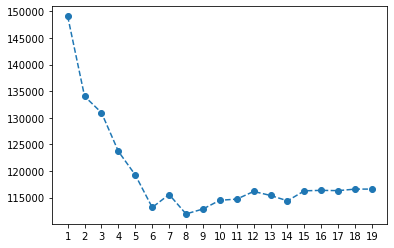

In [148]:
plt.plot(range(1, 20), mean_cv_errors, '--o')
plt.xticks(range(1, 20));

We see that cross-validation selects a 8-variable model.
Backward selection would have also chosen an 8 variable model, and best subset selection a 10 variable model (try this).
We now perform best subset selection on the full data set in order to obtain the 8-variable model.

In [149]:
model_best = forward_selection(y, X, 8)
model_best[model_best.k == 8].iloc[0].model.params

const         117.152043
CRBI            0.527324
Hits            6.854914
PutOuts         0.275389
AtBat          -2.033921
Walks           6.440664
CWalks         -0.806606
CRuns           0.704539
Division_W   -123.779837
dtype: float64

Finally, Scikit-Learn han an implementation for forward and backward subset selection that uses cross-validation that we can use with linear and non-linear models. So we dont have to implement the dummy coding inside our custom functions as before, we'll be using data processing pipelines to build a sequential model with both the dummy coding and the linear regression as part of the same model.
From the Scikit-Learn documentation on the SequentialFeatureSelector:

SFS is a greedy procedure where, at each iteration, we choose the best new feature to add to our selected features based a cross-validation score. That is, we start with 0 features and choose the best single feature with the highest score. The procedure is repeated until we reach the desired number of selected features.

We can also go in the reverse direction (backward SFS), i.e. start with all the features and greedily choose features to remove one by one.

Unfortunately a required parameter for SequentialFeatureSelector, feature_groups, needed to wok with one hot enconded data, has note yet reached the stable release of Scikit-Learn, so we delay its introduction to a later date.

## Ridge Regression and the Lasso

We will now perform ridge regression and the lasso in order to predict `Salary` on the `Hitters` data. Before proceeding ensure that the missing values have been removed from the data, as described in Section 6.5.1.
Scikit-Learn provides the `Ridge` and `Lasso` functions, which can be used to fit ridge regression models and lasso models.

In [148]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [150]:
X_dummies = pd.get_dummies(X, drop_first=True)
X_scaled = scale(X_dummies)
X_scaled

array([[-0.6029005 , -0.59567545, -0.5285512 , ...,  1.05875764,
         0.98116592,  1.07505242],
       [ 0.51254171,  0.49225957,  0.72996619, ..., -0.94450322,
         0.98116592, -0.9301872 ],
       [ 0.62816682,  0.73648988,  0.95878753, ...,  1.05875764,
        -1.01919561,  1.07505242],
       ...,
       [ 0.48533581,  0.40344855, -0.98619389, ..., -0.94450322,
         0.98116592, -0.9301872 ],
       [ 1.15188054,  0.80309815, -0.29972986, ..., -0.94450322,
        -1.01919561, -0.9301872 ],
       [ 1.54636621,  1.38036979, -0.29972986, ..., -0.94450322,
         0.98116592, -0.9301872 ]])

### Ridge Regression

The `Ridge` function has an `alpha` argument that sets the strenght of the regularization, this is the $\lambda$ constant described in the text.

In [151]:
grid = 10**np.linspace(10, -2, 100)*0.5
grid

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

In [152]:
ridge_models = []
ridge_coeffs = np.zeros((20, 100))
for i, alpha in enumerate(grid):
    ridge = Ridge(alpha=alpha).fit(X_scaled, y)
    ridge_models.append(ridge)
    ridge_coeffs[0, i] = ridge.intercept_
    ridge_coeffs[1:, i] = ridge.coef_
ridge_coeffs.shape

(20, 100)

We have chosen to implement the function over a grid of values ranging from $\lambda=10^{10}$ to $\lambda=10^{-2}$, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit. 

Associated with each value of $\lambda$ is a vector of ridge regression coefficients, that can be accesed using each models `coef_` and `_intercept` parameters. In this case, we store thos values in a $20 \times 100$
matrix, with $20$ rows (one for each predictor, plus an intercept) and $100$ columns (one for each value of $\lambda$).

We expect the coefficient estimates to be much smaller, in terms of $\ell_2$ norm, when a large value of $\lambda$ is used, as compared to when a small value of
$\lambda$ is used. 

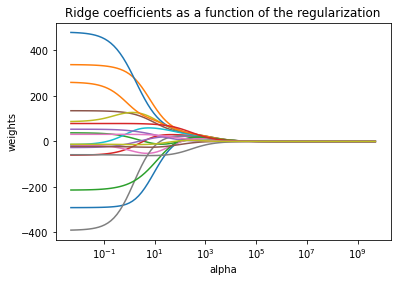

In [153]:
plt.semilogx(grid, ridge_coeffs.T[:,1:])
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

These are the coefficients when $\lambda=5749$, along with their $\ell_2$ norm:

In [155]:
print('alpha = ', grid[49])
print(pd.Series(ridge_coeffs[1:, 49], index=X_dummies.columns))
np.sqrt(np.sum(ridge_coeffs[1:, 49]**2))

alpha =  5748.784976988678
AtBat          6.119195
Hits           7.044081
HmRun          5.140181
Runs           6.642274
RBI            6.980811
Walks          7.102608
Years          5.933660
CAtBat         8.037516
CHits          8.493838
CHmRun         8.086276
CRuns          8.706860
CRBI           8.777422
CWalks         7.402013
PutOuts        5.272743
Assists        0.430635
Errors        -0.165127
League_N       0.089851
Division_W    -3.583274
NewLeague_N    0.201854
dtype: float64


27.252015024953984

In contrast, here are the coefficients when $\lambda=83$, along with their $\ell_2$ norm. Note the much larger $\ell_2$ norm of the coefficients associated with this smaller value of $\lambda$.

In [156]:
print('alpha = ', grid[59])
print(pd.Series(ridge_coeffs[1:, 59], index=X_dummies.columns))
np.sqrt(np.sum(ridge_coeffs[1:, 59]**2))

alpha =  352.74011553593226
AtBat          15.999998
Hits           31.197529
HmRun           9.583819
Runs           24.666884
RBI            22.222669
Walks          29.953068
Years          11.677600
CAtBat         25.195751
CHits          31.572862
CHmRun         28.809570
CRuns          32.228725
CRBI           32.947883
CWalks         18.472021
PutOuts        35.751428
Assists         2.597663
Errors         -5.380023
League_N        7.634795
Division_W    -29.748432
NewLeague_N     4.511881
dtype: float64


103.25500303515861

We now split the samples into a training and a test set in order to estimate the test error of ridge regression. Even if we are using cross validation to select the regularization parameter, a test set is still needed to assert the test error once $\lambda$ has been chose. Reporting the cross validation error as test error is not correct, as the value has been tuned as to minimize such error, so the error estimate is biased.

In [225]:
X_train, X_test , y_train, y_test = train_test_split(X_dummies, y, test_size=0.5, random_state=1)

# Create a scaler
scaler = StandardScaler(with_mean=False)

# Now train an scaler on the train set
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

Next we fit a ridge regression model on the training set, and evaluate its MSE on the test set, using  λ=4 :

In [163]:
ridge2 = Ridge(alpha=4).fit(X_train_s, y_train)  # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test_s)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index=X_train.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

AtBat         -210.807322
Hits           193.076932
HmRun          -51.437368
Runs             1.624070
RBI             81.458917
Walks           94.582539
Years          -28.029476
CAtBat        -117.924364
CHits           91.159632
CHmRun          91.762010
CRuns          101.115450
CRBI           117.598963
CWalks         -38.434685
PutOuts        125.556071
Assists         25.559188
Errors         -18.518904
League_N        35.792050
Division_W     -60.245442
NewLeague_N    -18.650623
dtype: float64
102144.52395076491


The test MSE when alpha = 4 is 102144. Now let's see what happens if we use a huge value of alpha, say $10^{10}$ :

In [164]:
ridge3 = Ridge(alpha=10**10).fit(X_train_s, y_train)  # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test_s)           # Use this model to predict the test data
print(pd.Series(ridge3.coef_, index=X_train.columns)) # Print coefficients
print(mean_squared_error(y_test, pred3))          # Calculate the test MSE

AtBat          2.526133e-06
Hits           2.826091e-06
HmRun          2.174902e-06
Runs           2.632138e-06
RBI            3.183658e-06
Walks          2.941154e-06
Years          2.478179e-06
CAtBat         3.213788e-06
CHits          3.432349e-06
CHmRun         3.435819e-06
CRuns          3.522298e-06
CRBI           3.602930e-06
CWalks         3.216811e-06
PutOuts        2.851209e-06
Assists       -4.856786e-08
Errors         1.736624e-07
League_N      -1.637144e-07
Division_W    -1.015188e-06
NewLeague_N   -1.325154e-07
dtype: float64
172862.22059245987


This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This over-shrinking makes the model more biased, resulting in a higher MSE.

Okay, so fitting a ridge regression model with alpha = 4 leads to a much lower test MSE than fitting a model with just an intercept. We now check whether there is any benefit to performing ridge regression with alpha = 4 instead of just performing least squares regression. Recall that least squares is simply ridge regression with alpha = 0.

In [165]:
ridge4 = Ridge(alpha=0).fit(X_train_s, y_train)  # Fit a ridge regression on the training data
pred4 = ridge4.predict(X_test_s)           # Use this model to predict the test data
print(pd.Series(ridge4.coef_, index=X_train.columns)) # Print coefficients
print(mean_squared_error(y_test, pred4))          # Calculate the test MSE

AtBat          -266.553048
Hits            197.706218
HmRun           -38.103182
Runs             -1.007996
RBI             103.119845
Walks            79.750209
Years            45.357697
CAtBat        -1399.811384
CHits          1426.954812
CHmRun          264.037977
CRuns            86.858781
CRBI           -211.142393
CWalks           42.533597
PutOuts         126.075563
Assists          65.816094
Errors          -38.313885
League_N         66.822855
Division_W      -56.870280
NewLeague_N     -40.962688
dtype: float64
116690.46856660652


It looks like we are indeed improving over regular least-squares!

In general,  if we want to fit a (unpenalized) least squares model, then we should use the `LinearRegression()` function, since its numerically more stable for that case.

In general, instead of arbitrarily choosing a $\lambda$ value, it would be better to use cross-validation to choose the tuning parameter $\lambda$.
We can do this using the built-in cross-validation function, `RidgeCV`.  By default, the function performs five-fold cross-validation, though this can be changed using the argument `cv`.

In [192]:
X_train_s

array([[-1.22544785, -0.95709474, -0.92570099, ..., -1.03892496,
         0.99239533, -1.00766295],
       [ 0.8036835 ,  0.44319078, -1.17625229, ...,  0.96253342,
         0.99239533,  0.99239533],
       [ 1.70551966,  2.27433337,  0.32705552, ...,  0.96253342,
         0.99239533,  0.99239533],
       ...,
       [-0.07082428,  0.2923908 ,  0.20177987, ...,  0.96253342,
         0.99239533,  0.99239533],
       [-0.88384324, -0.76320905, -1.30152795, ...,  0.96253342,
        -1.00766295,  0.99239533],
       [ 0.44158262, -0.09538058,  0.32705552, ..., -1.03892496,
         0.99239533, -1.00766295]])

In [260]:
ridge_cv = RidgeCV(alphas=grid, scoring='neg_mean_squared_error', cv=10).fit(X_train_s, y_train)
ridge_cv.alpha_

66.09705742330144

Therefore, we see that the value of alpha that results in the smallest cross-validation error is 66.09. What is the test MSE associated with this value of alpha?

In [269]:
ridge = Ridge(alpha=ridge_cv.alpha_).fit(X_train_s, y_train)
pred = ridge.predict(X_test_s) 
print(mean_squared_error(y_test, pred))

99980.09304227545


This represents a further improvement over the test MSE that we got using alpha=4 . Finally, we refit our ridge regression model on the full data set, using the value of alpha chosen by cross-validation, and examine the coefficient estimates.

In [270]:
ridge = Ridge(alpha=ridge_cv.alpha_).fit(X_scaled, y)
print(pd.Series(ridge.coef_, index=X_train.columns))

AtBat         -12.315751
Hits           59.087964
HmRun          -5.002506
Runs           29.619573
RBI            22.059137
Walks          45.860959
Years         -10.825321
CAtBat         22.919293
CHits          51.084062
CHmRun         42.944375
CRuns          51.804166
CRBI           54.020476
CWalks         -7.193088
PutOuts        62.138342
Assists        10.160514
Errors        -16.486264
League_N       17.541464
Division_W    -53.161910
NewLeague_N     0.736461
dtype: float64


As expected, none of the coefficients are zero---ridge regression does not perform variable selection!

### The Lasso

We saw that ridge regression with a wise choice of $\lambda$ can outperform least squares as well as the null model on the `Hitters` data set. We now ask whether the lasso can yield either
a more accurate or a more interpretable model than ridge regression. In order to fit a lasso model, we use the `Lasso()` function.

Tha Lasso function provides a convenient and efficient way of evaluating the coefficients along the different values of alpha automatically.

In [275]:
lasso_path = Lasso().path(X_scaled, y, l1_ratio=1, alphas=grid, max_iter=10000)

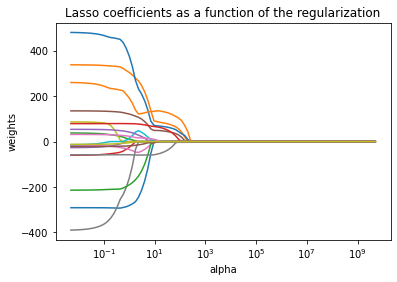

In [276]:
alphas, coeffs, dual_gaps  = lasso_path
plt.semilogx(alphas, coeffs.T)
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

We can see from the coefficient plot that depending on the choice of tuning parameter, some of the coefficients will be exactly equal to zero.

And also provides an estimator which automatically performs cross-validation.
We now perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [278]:
lasso_cv = LassoCV(alphas=None, max_iter=10000, cv=10).fit(X_train_s, y_train)

In [279]:
lasso = Lasso(alpha=lasso_cv.alpha_).fit(X_train_s, y_train)
mean_squared_error(y_test, lasso.predict(X_test_s))

104960.65853895506

This is substantially lower than the test set MSE of the null model and of least squares, and only a little worse than the test MSE of ridge regression with alpha chosen by cross-validation.

In [280]:
pd.Series(lasso.coef_, X_train.columns)

AtBat            0.000000
Hits            50.246197
HmRun            0.000000
Runs             0.000000
RBI              0.000000
Walks           66.794424
Years            0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun          19.441152
CRuns            0.000000
CRBI           181.336557
CWalks           0.000000
PutOuts        110.307327
Assists         -0.000000
Errors          -0.000000
League_N         0.000000
Division_W     -44.530872
NewLeague_N      0.000000
dtype: float64

This is substantially lower than the test set MSE of the null model and of least squares, and very similar to the test MSE of ridge regression with $\lambda$ chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in that the resulting coefficient estimates are sparse. Here we see that 13 of the 19 coefficient estimates are exactly
zero. So the lasso model with $\lambda$ chosen by cross-validation contains only 6 variables.

## PCR and PLS Regression

### Principal Components Regression

Principal components regression (PCR) can be performed  as a combination of the `PCA()` and `LinearRegression()` functions. We now apply PCR to the `Hitters` data, in order to predict `Salary`. Again,
we ensure that the missing values have been removed from the data, as described in Section 6.5.1.

In [286]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA 
from sklearn.model_selection import KFold, cross_val_score

We'll start by performing PCA on standardized data.

In [281]:
pca = PCA().fit(X_scaled)
X_pca = pca.transform(X_scaled)

The first principal components are:

In [284]:
pd.DataFrame(pca.components_.T).loc[:4]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646,0.107044,0.269810,-0.012183,0.145621,0.097328,0.103150,-0.039850,0.306248,0.532433,-0.510331,0.139342,-0.106790,0.053777
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240,0.130026,0.388722,-0.061604,0.130476,0.014433,0.121009,0.003593,0.210616,-0.023442,0.720168,-0.167363,0.043568,-0.097782
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646,-0.505833,-0.226278,0.127422,-0.351111,-0.202190,-0.314852,-0.108689,-0.001353,0.355455,0.200408,0.047702,-0.058377,-0.024805
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660,0.201764,0.114518,-0.171230,0.032245,-0.312187,-0.321700,-0.381219,-0.266583,-0.468300,-0.220518,0.140946,0.047050,0.059145
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675,-0.319440,0.005082,0.131146,-0.172233,0.243415,0.347752,0.440143,-0.007486,-0.461468,-0.237366,-0.106688,0.063998,0.019351


The retained variance grows with the number of components kept.
This concept is discussed in greater detail in Chapter 12.
   Briefly, we can think of this as
the amount of information about the predictors or the
response that is captured using $M$ principal components. For example,
setting $M=1$ only captures $38.31\,\%$ of all the variance, or information,
in the predictors. In contrast, using $M=5$ increases the value to $84.29\,\%$. If we
were to use all $M=p=19$ components, this would increase to $100\,\%$.

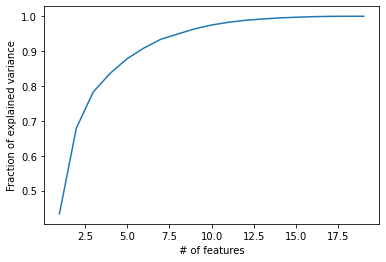

In [123]:
plt.plot(range(1, len(X_scaled.columns) + 1), pca.explained_variance_ratio_.cumsum())
plt.xlabel('# of features')
plt.ylabel('Fraction of explained variance');

Now we'll perform 10-fold cross-validation to see how it influences the MSE:

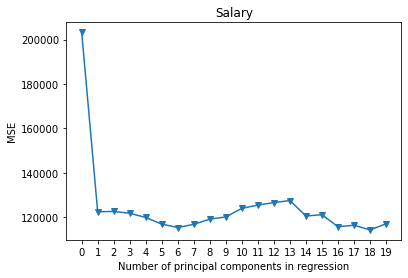

In [294]:
# 10-fold CV, with shuffle
n = len(X_pca)
cv = KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = abs(cross_val_score(regr, np.ones((n, 1)), y.ravel(), cv=cv, scoring='neg_mean_squared_error')).mean()
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = abs(cross_val_score(regr, X_pca[:,:i], y.ravel(), cv=cv, scoring='neg_mean_squared_error')).mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xticks(range(20));

In [295]:
np.argmin(mse)

18

We see that the smallest cross-validation error occurs when $M=18$ components are used. This is barely fewer than $M=19$, which amounts to simply performing least squares, because when all of the components are used in PCR no dimension reduction occurs. However, from the plot we also see that the cross-validation error is roughly the same when only one component is included in the model. This suggests that a model that uses just a small number of components might suffice.

We now
perform PCR on the training data and evaluate its test set performance.

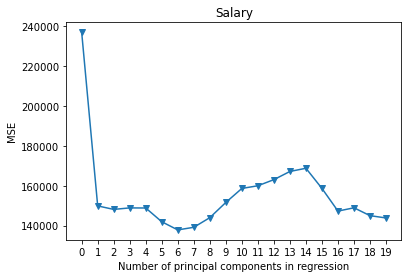

In [296]:
pca2 = PCA().fit(X_train_s)
X_pca_train = pca2.transform(X_train_s)
n = len(X_pca_train)

# 10-fold CV, with shuffle
cv = KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = abs(cross_val_score(regr, np.ones((n, 1)), y_train.ravel(), cv=cv, scoring='neg_mean_squared_error')).mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = abs(cross_val_score(regr, X_pca_train[:,:i], y_train.ravel(), cv=cv, scoring='neg_mean_squared_error')).mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xticks(range(20));

Now we find that the lowest cross-validation error occurs when $M=6$ components are used.
We compute the test MSE as follows.

In [297]:
X_pca_test = pca2.transform(X_test_s)[:, :7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_pca_train[:, :7], y_train)

# Prediction with test data
pred = regr.predict(X_pca_test)
mean_squared_error(y_test, pred)

108266.9590347202

This test set MSE is competitive with the results obtained using ridge regression and the lasso. However, as a result of the way PCR is implemented, the final model is more difficult to interpret because it does not perform any kind of variable selection or even directly produce coefficient estimates.

Finally, we fit PCR on the full data set, using $M=6$, the number of components identified by cross-validation.

In [298]:
regr = LinearRegression()
regr.fit(X_pca[:, :7], y)

LinearRegression()

### Partial Least Squares

Scikit-learn PLSRegression gives same results as the pls package in R when using method='oscorespls'. However, the standard method used is 'kernelpls', which we'll use here. Feel free to try out both.

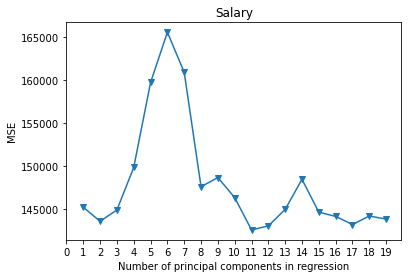

In [299]:
n = len(X_train)

# 10-fold CV, with shuffle
cv = KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, X_train_s, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(abs(score))

# Plot results
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xticks(range(20));

The lowest cross-validation error occurs when only $M=2$ partial least squares directions are used. We now evaluate the corresponding test set MSE.

In [300]:
pls = PLSRegression(n_components=2)
pls.fit(X_train_s, y_train)

mean_squared_error(y_test, pls.predict(X_test_s))

102583.13156134987

The test MSE is again comparable to the test MSE obtained using ridge regression, the lasso, and PCR.

Finally, we perform PLS using the full data set, using $M=2$, the number of components identified by cross-validation.

In [304]:
pls = PLSRegression(n_components=2)
pls.fit(X_scaled, y)
pls.score(X_scaled, y)

0.4640256822231318

In [306]:
regr.score(X_pca[:, :7], y)

0.46686410736336714

Notice that the percentage of variance in `Salary` that the two-component PLS fit explains, $46.4\,\%$, is almost as much as that explained using the final six-component model PCR fit. This is because PCR only attempts to maximize the amount of variance explained in the predictors, while PLS searches for directions that explain variance in both the predictors and the response.